In [19]:
import pandas as pd
import numpy as np
import os
# import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text as tx
from scipy import sparse
from nltk.corpus import words as nltk_words
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from langdetect import detect
import enchant
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score as auc, average_precision_score as ap
from nltk import word_tokenize

# Installed Libraries by Sammie
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sn
import time
import warnings
warnings.filterwarnings('ignore')


In [2]:
plt.style.use('seaborn-darkgrid')
%matplotlib inline

# Use Enchant English Dictionary
d = enchant.Dict("en_US")

In [3]:
df_trn = pd.read_csv(os.path.join('/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master', 'train.csv'), parse_dates=['date'], index_col=['ex_id'])

In [4]:
df_val = pd.read_csv(os.path.join('/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master', 'dev.csv'), parse_dates=['date'], index_col=['ex_id'])

In [5]:
print("***********************************************************************************")
print("Training data has {} rows and {} columns".format(df_trn.shape[0], df_trn.shape[1]))
print("Validation data has {} rows and {} columns".format(df_val.shape[0], df_val.shape[1]))
print("***********************************************************************************")

***********************************************************************************
Training data has 250874 rows and 6 columns
Validation data has 35918 rows and 6 columns
***********************************************************************************


### Baseline 1: Review Data Only

In [6]:
y_trn = df_trn['label']
y_val = df_val['label']

In [7]:
df_eval = pd.DataFrame(columns=['model','trans', 'preproc', 'set', 'auc', 'ap'])

In [20]:
df_eval = pd.DataFrame(columns=['model','trans', 'preproc', 'set', 'auc', 'ap'])

def evaluation_metrix(train_y, pred_train_y, val_y, pred_val_y):
    """ This function calculates AUC and Average Precision on Training and Validation data"""
    auc_trn, auc_val, ap_trn, ap_val = 0.0, 0.0, 0.0, 0.0
    auc_trn = metrics.roc_auc_score(train_y, pred_train_y[:, 1])
    print("AUC value on Train data: {}".format(auc_trn))
    auc_val = metrics.roc_auc_score(val_y, pred_val_y[:, 1])
    print("AUC value on Validation data: {}".format(auc_val))
    ap_trn = metrics.average_precision_score(train_y, pred_train_y[:, 1])
    print("Average Precision on Training data: {}".format(ap_trn))
    ap_val = metrics.average_precision_score(val_y, pred_val_y[:, 1])
    print("Average Precision on Validation data: {}".format(ap_val))
    
    return auc_trn, auc_val, ap_trn, ap_val


def plot_roc_curve(y_validation, yhat_validation):
    """ This function plots the auc-roc curve """
    fpr, tpr, _ = metrics.roc_curve(y_validation,  yhat_validation[::,1])
    auc_ = metrics.roc_auc_score(y_validation, yhat_validation[::,1])
    plt.plot(fpr,tpr,label="data, auc="+str(auc_))
    plt.legend(loc=4)
    plt.show()
    
    
def plot_confusion_matrix(model, validation_train, validation_true):
    """ This plots heatmap of confusion matrix """
    yhat_pred = model.predict(validation_train)
    data = confusion_matrix(validation_true, yhat_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_val), index = np.unique(y_val))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    
    
# Time taken to run Linear SVM classifier
def combined (X_trn, X_val,y_trn, trans, preproc, df_eval, validation_true_val):
    start = pd.Timestamp.now()
    base_model = SGDClassifier(loss='perceptron', penalty='l1',alpha=1e-3, random_state=42, max_iter=5, tol=None)
    model = CalibratedClassifierCV(base_model).fit(X_trn, y_trn)
    end = pd.Timestamp.now() 
    print("Time taken to run Linear SVM classifier: {} seconds".format((end - start)/pd.Timedelta('1s')))

    # Compute predictions
    yhat_trn = model.predict_proba(X_trn)
    yhat_val = model.predict_proba(X_val)

    # print(auc_trn, auc_val, ap_trn, ap_val)
    auc_trn_cl, auc_val_cl, ap_trn_cl, ap_val_cl = evaluation_metrix(train_y=y_trn, 
                                                                     pred_train_y=yhat_trn, 
                                                                     val_y=validation_true_val, 
                                                                     pred_val_y=yhat_val)
   
    print(auc_trn_cl, auc_val_cl, ap_trn_cl, ap_val_cl)
    # Plot confusion matrix
    
    
    
    # Plot ROC curve
    
    plot_confusion_matrix(model=model, validation_train=X_val, validation_true=validation_true_val)
    fig, ax = plt.subplots(nrows=1)
    plot_roc_curve(y_validation=validation_true_val, yhat_validation=yhat_val)
   

   
    df_eval = df_eval.append({'trans':trans, 
                              'preproc':preproc, 
                              'set':'trn', 
                              'auc':auc_trn_cl, 
                              'ap':ap_trn_cl,
                              'model': 'Linear SVMClassifier'}, ignore_index=True)
    df_eval = df_eval.append({'trans':trans, 
                              'preproc':preproc, 
                              'set':'val',
                              'auc':auc_val_cl,
                              'ap':ap_val_cl,
                              'model': 'Linear SVMClassifier'}, ignore_index=True)
    
    
    
#     print(df_eval)
    
    
    return df_eval

In [21]:
# Train Count Vectorizer
start = pd.Timestamp.now()
count_trans = tx.CountVectorizer(strip_accents='unicode').fit(df_trn['review'])
end = pd.Timestamp.now() 
print("Time Taken to create Count Vectorizer object: {} seconds".format((end - start)/pd.Timedelta('1s')))
X_trn_none = count_trans.transform(df_trn['review'])
X_val_none = count_trans.transform(df_val['review'])


X_trn_count = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/wordcount_train.npz'
X_val_count = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/wordcount_valid.npz'

X_trn_tfidfraw = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_train.npz'
X_val_tfidfraw = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_valid.npz'

X_trn_tfidfrawtrim = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_trim_train.npz'
X_val_tfidfrawtrim = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_trim_valid.npz'

X_trn_tfidfnorm = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_train.npz'
X_val_tfidfnorm = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_valid.npz'

X_trn_tfidfnormtrim = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_trim_train.npz'
X_val_tfidfnormtrim = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_trim_valid.npz'




Time Taken to create Count Vectorizer object: 191.261801 seconds


Time taken to run Linear SVM classifier: 20.538342 seconds
AUC value on Train data: 0.6217910200104125
AUC value on Validation data: 0.6184399277749688
Average Precision on Training data: 0.15282961765925868
Average Precision on Validation data: 0.14747102345305044
0.6217910200104125 0.6184399277749688 0.15282961765925868 0.14747102345305044


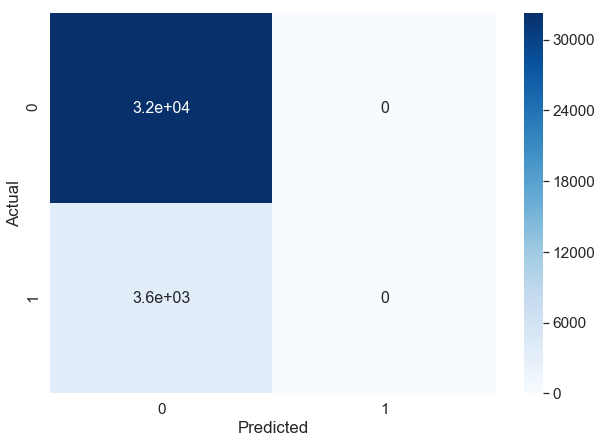

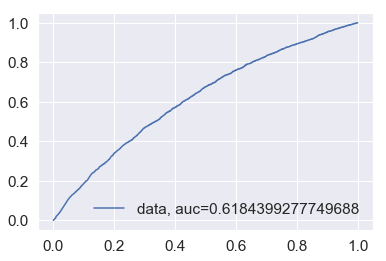

Time taken to run Linear SVM classifier: 14.357513 seconds
AUC value on Train data: 0.6446001175406719
AUC value on Validation data: 0.6355349336260935
Average Precision on Training data: 0.16211574567323297
Average Precision on Validation data: 0.15434625980716302
0.6446001175406719 0.6355349336260935 0.16211574567323297 0.15434625980716302


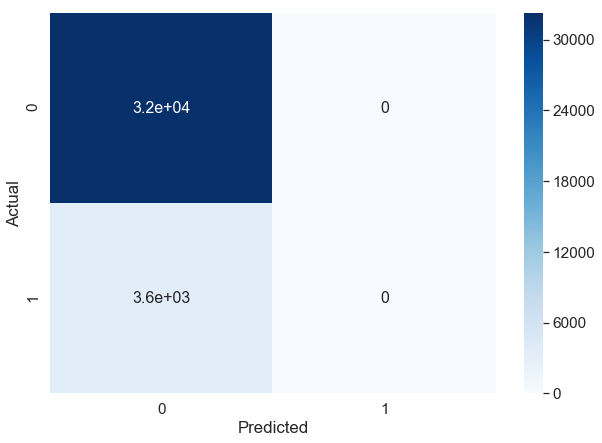

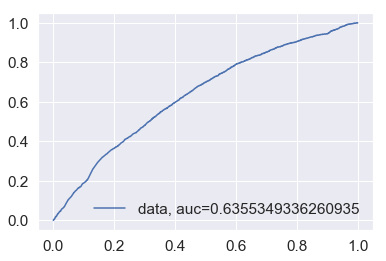

Time taken to run Linear SVM classifier: 11.764749 seconds
AUC value on Train data: 0.6615682492764512
AUC value on Validation data: 0.6478747327578708
Average Precision on Training data: 0.16743365630171858
Average Precision on Validation data: 0.15546262247500697
0.6615682492764512 0.6478747327578708 0.16743365630171858 0.15546262247500697


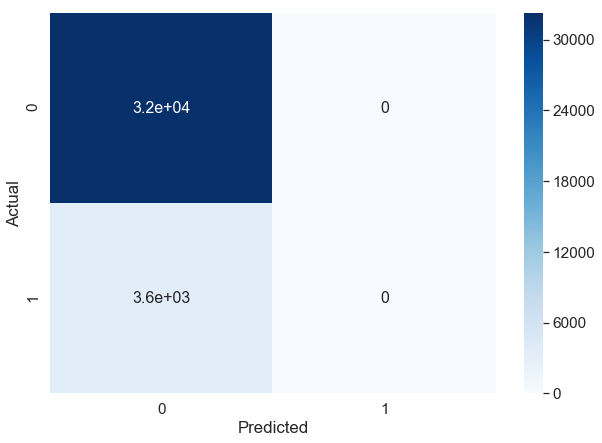

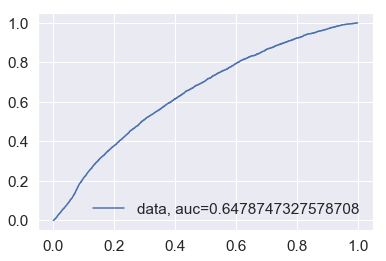

Time taken to run Linear SVM classifier: 7.365772 seconds
AUC value on Train data: 0.6568155311788523
AUC value on Validation data: 0.6441832151215893
Average Precision on Training data: 0.16484378519384812
Average Precision on Validation data: 0.15095169136584183
0.6568155311788523 0.6441832151215893 0.16484378519384812 0.15095169136584183


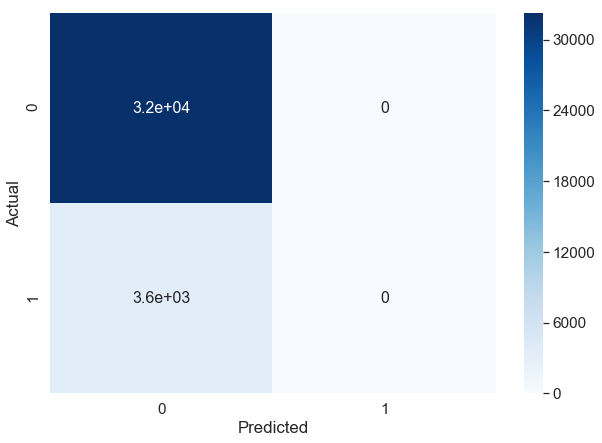

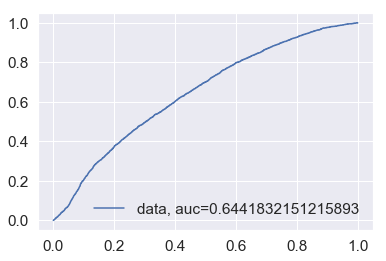

Time taken to run Linear SVM classifier: 11.473597 seconds
AUC value on Train data: 0.5860414960909379
AUC value on Validation data: 0.5800784329315698
Average Precision on Training data: 0.13536005339629759
Average Precision on Validation data: 0.13003188842120716
0.5860414960909379 0.5800784329315698 0.13536005339629759 0.13003188842120716


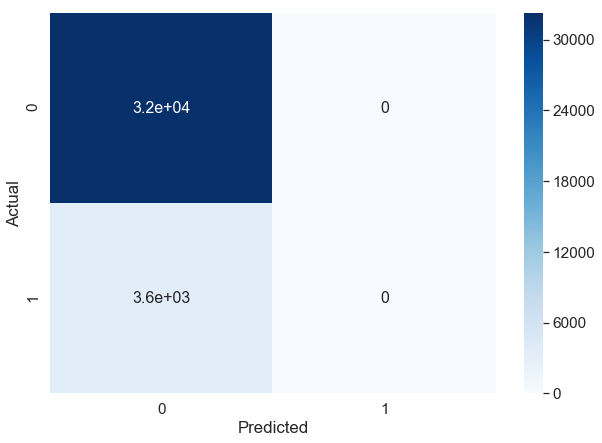

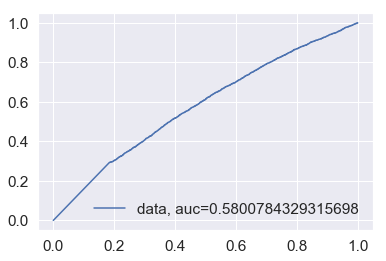

Time taken to run Linear SVM classifier: 10.00736 seconds
AUC value on Train data: 0.6085764019818733
AUC value on Validation data: 0.6007020627422678
Average Precision on Training data: 0.15372918463665095
Average Precision on Validation data: 0.1450218366387344
0.6085764019818733 0.6007020627422678 0.15372918463665095 0.1450218366387344


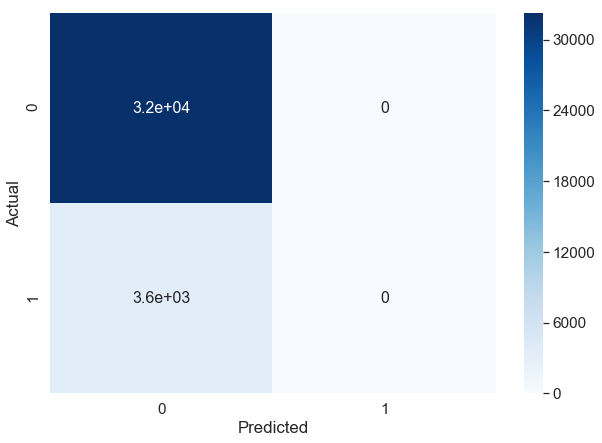

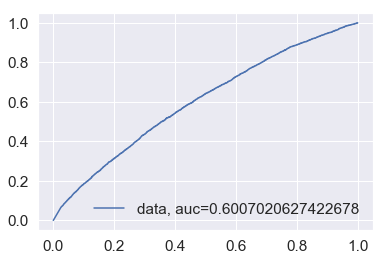

In [22]:
create_paths = [[X_trn_none, X_val_none], [X_trn_count,X_val_count ], [X_trn_tfidfraw, X_val_tfidfraw], [X_trn_tfidfrawtrim, X_val_tfidfrawtrim], 
               [X_trn_tfidfnorm, X_val_tfidfnorm], [X_trn_tfidfnormtrim, X_val_tfidfnormtrim]]

results = pd.DataFrame()
import scipy.sparse as sps
for file_name in create_paths:
    try:

#         below takes care of Count vectorizer with No preprocessing
        if sps.isspmatrix_csr(file_name[0]):
            X_trn=file_name[0]
            X_val=file_name[1]
            preproc = None
            trans = "count"
            results = results.append(combined (X_trn=X_trn, 
                                               X_val=X_val, 
                                               y_trn=y_trn, 
                                               trans=trans, 
                                               preproc=preproc, 
                                               df_eval=df_eval,
                                               validation_true_val=y_val))
    
            
        else:
            # below code takes care of all the other cases
            trans = file_name[0].split("/")[-1].split(".")[0].split('_')

            if len(trans) <= 2:
                trans = trans[0]
            else:
                trans = trans[0] + "_" + trans[1]
            preproc = "lem"
            X_trn=sparse.load_npz(file_name[0])
            X_val = sparse.load_npz(file_name[1])
            results =results.append(combined (X_trn=X_trn, 
                                               X_val=X_val, 
                                               y_trn=y_trn, 
                                               trans=trans, 
                                               preproc=preproc, 
                                               df_eval=df_eval,
                                               validation_true_val=y_val))
     
    except Exception as e:
        print("trace: {}".format(e))
    
   

    

In [24]:
results

,model,trans,preproc,set,auc,ap
0,Linear SVMClassifier,count,None,trn,0.621791,0.152830
1,Linear SVMClassifier,count,None,val,0.618440,0.147471
0,Linear SVMClassifier,wordcount,lem,trn,0.644600,0.162116
1,Linear SVMClassifier,wordcount,lem,val,0.635535,0.154346
0,Linear SVMClassifier,tfidfraw,lem,trn,0.661568,0.167434
1,Linear SVMClassifier,tfidfraw,lem,val,0.647875,0.155463
0,Linear SVMClassifier,tfidfraw_trim,lem,trn,0.656816,0.164844
1,Linear SVMClassifier,tfidfraw_trim,lem,val,0.644183,0.150952
0,Linear SVMClassifier,tfidfnorm,lem,trn,0.586041,0.135360
1,Linear SVMClassifier,tfidfnorm,lem,val,0.580078,0.130032


## Up Samples

In [25]:
df_trn_up = pd.read_csv('/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/df_train_up.csv')
df_trn_up.head()

,ex_id,user_n_reviews,user_avg_rating,user_review_intensity,prod_n_reviews,prod_avg_rating,prod_review_intensity,word_count,pct_en,label
0,15,1,5.0,1.000000,227,3.969163,0.064507,27,92.592593,0
1,16,1,3.0,1.000000,227,3.969163,0.064507,160,99.375000,0
2,18,1,5.0,1.000000,227,3.969163,0.064507,40,100.000000,0
3,19,2,3.5,2.000000,227,3.969163,0.064507,8,100.000000,0
4,21,6,3.5,0.010714,227,3.969163,0.064507,35,100.000000,0


In [26]:
y_trn_up = df_trn_up['label']

In [27]:
y_trn_up.value_counts()

1    225055
0    225055
Name: label, dtype: int64

In [28]:
X_trn_countup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/wordcount_train_up.npz'
X_val_countup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/wordcount_valid_up.npz'

X_trn_tfidfrawup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_train_up.npz'
X_val_tfidfrawup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_valid_up.npz'

X_trn_tfidfnormup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_train_up.npz'
X_val_tfidfnormup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_valid_up.npz'

Time taken to run Linear SVM classifier: 18.885762 seconds
AUC value on Train data: 0.6192434897168978
AUC value on Validation data: 0.6116416439349459
Average Precision on Training data: 0.5786630401213677
Average Precision on Validation data: 0.13093363427355093
0.6192434897168978 0.6116416439349459 0.5786630401213677 0.13093363427355093


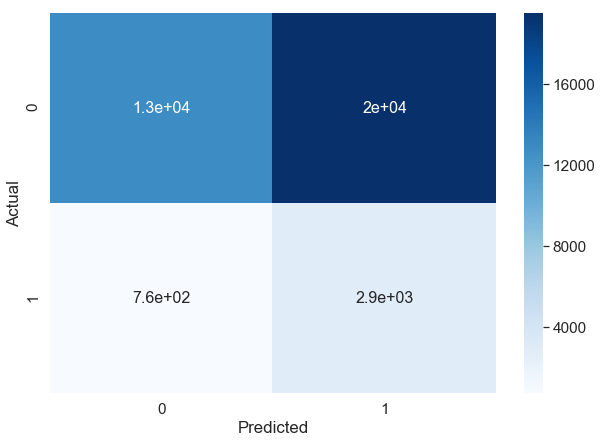

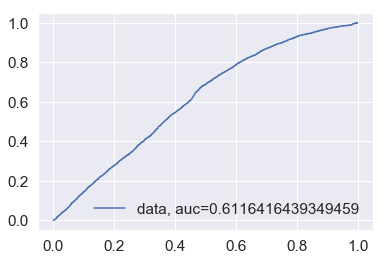

Time taken to run Linear SVM classifier: 18.998247 seconds
AUC value on Train data: 0.6192434897168978
AUC value on Validation data: 0.6116416439349459
Average Precision on Training data: 0.5786630401213677
Average Precision on Validation data: 0.13093363427355093
0.6192434897168978 0.6116416439349459 0.5786630401213677 0.13093363427355093


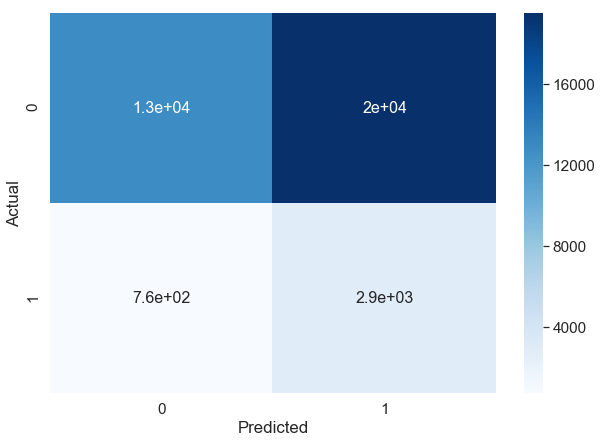

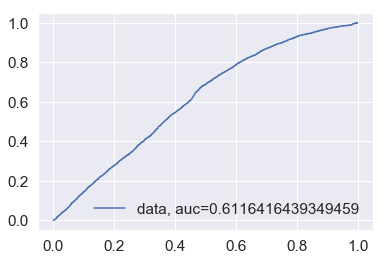

Time taken to run Linear SVM classifier: 11.540711 seconds
AUC value on Train data: 0.5890514173736191
AUC value on Validation data: 0.602200687116381
Average Precision on Training data: 0.5851352575971642
Average Precision on Validation data: 0.15046243880061524
0.5890514173736191 0.602200687116381 0.5851352575971642 0.15046243880061524


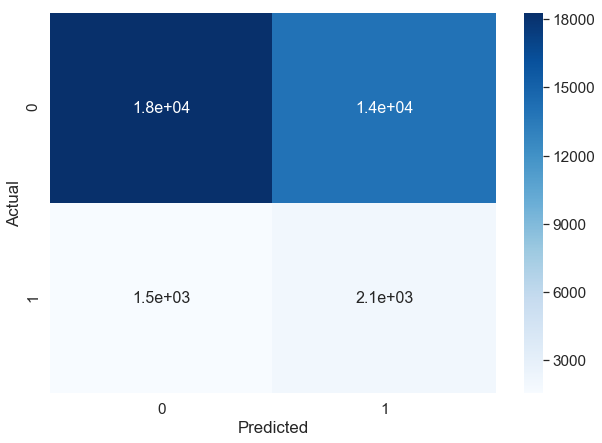

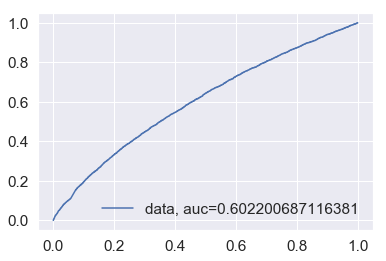

In [29]:
create_paths = [[X_trn_countup,X_val_countup],[X_trn_tfidfrawup, X_val_tfidfrawup], 
                [X_trn_tfidfnormup, X_val_tfidfnormup]]
results_up = pd.DataFrame()
import scipy.sparse as sps
for file_name in create_paths:
    try:

#         below takes care of Count vectorizer with No preprocessing
        if sps.isspmatrix_csr(file_name[0]):
            X_trn=file_name[0]
            X_val=file_name[1]
            preproc = None
            trans = "count"
            results = results.append(combined (X_trn, X_val, y_trn_up,  trans, preproc, df_eval, y_val))
            
        else:
            # below code takes care of all the other cases
            trans = file_name[0].split("/")[-1].split(".")[0].split('_')
            trans = trans[0] + "_" + "up"
            
            # for n-gram code:
#             trans = file_name[0].split("/")[-1].split(".")[0].split('_')
#               trans = trans[0] + "_" +trans[1] + "_" + trans[2]
              
#             
            preproc = "lem"
            X_trn=sparse.load_npz(file_name[0])
            X_val = sparse.load_npz(file_name[1])
            results_up = results_up.append(combined (X_trn, X_val, y_trn_up, trans, preproc, df_eval, y_val))
     
    except Exception as e:
        print("trace: {}".format(e))
    
   

In [30]:
results_up

,model,trans,preproc,set,auc,ap
0,Linear SVMClassifier,wordcount_up,lem,trn,0.619243,0.578663
1,Linear SVMClassifier,wordcount_up,lem,val,0.611642,0.130934
0,Linear SVMClassifier,tfidfraw_up,lem,trn,0.619243,0.578663
1,Linear SVMClassifier,tfidfraw_up,lem,val,0.611642,0.130934
0,Linear SVMClassifier,tfidfnorm_up,lem,trn,0.589051,0.585135
1,Linear SVMClassifier,tfidfnorm_up,lem,val,0.602201,0.150462


In [31]:
# precision = TP/TP+FP

# In training dataset, all your fake samples remians same. So,model learns it pretty well.
results_up.loc[results_up.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,wordcount_up,lem,val,0.611642,0.130934
1,Linear SVMClassifier,tfidfraw_up,lem,val,0.611642,0.130934
1,Linear SVMClassifier,tfidfnorm_up,lem,val,0.602201,0.150462


In [32]:
results.loc[results.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,count,None,val,0.618440,0.147471
1,Linear SVMClassifier,wordcount,lem,val,0.635535,0.154346
1,Linear SVMClassifier,tfidfraw,lem,val,0.647875,0.155463
1,Linear SVMClassifier,tfidfraw_trim,lem,val,0.644183,0.150952
1,Linear SVMClassifier,tfidfnorm,lem,val,0.580078,0.130032
1,Linear SVMClassifier,tfidfnorm_trim,lem,val,0.600702,0.145022


### ngrams analysis

In [33]:
X_ngram_snow_train = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_train.npz'
X_ngram_snow_val = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_valid.npz'

X_ngram_snow_tfidf_train = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_tfidf_train.npz'
X_ngram_snow_tfidf_val = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_tfidf_valid.npz'


/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_train.npz
ngram_snow_train
Time taken to run Linear SVM classifier: 68.215381 seconds
AUC value on Train data: 0.6374929420340971
AUC value on Validation data: 0.6360109321228776
Average Precision on Training data: 0.15708722572302816
Average Precision on Validation data: 0.15392110010399573
0.6374929420340971 0.6360109321228776 0.15708722572302816 0.15392110010399573


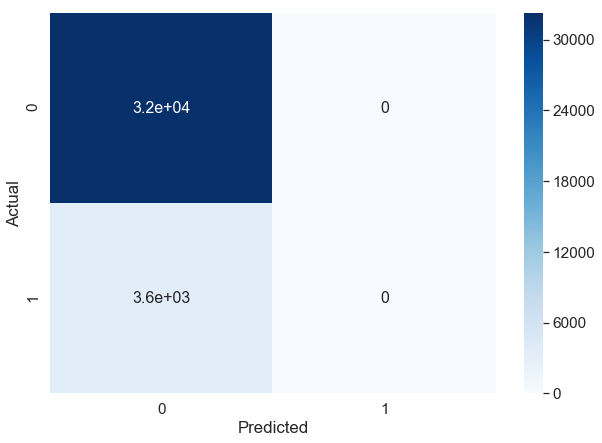

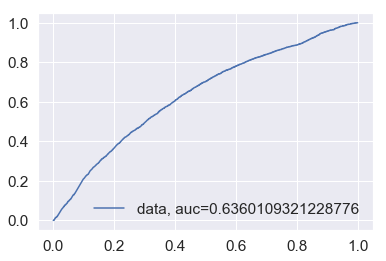

/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_tfidf_train.npz
ngram_snow_tfidf
Time taken to run Linear SVM classifier: 57.505129 seconds
AUC value on Train data: 0.5
AUC value on Validation data: 0.5
Average Precision on Training data: 0.10291620494750353
Average Precision on Validation data: 0.101564675093268
0.5 0.5 0.10291620494750353 0.101564675093268


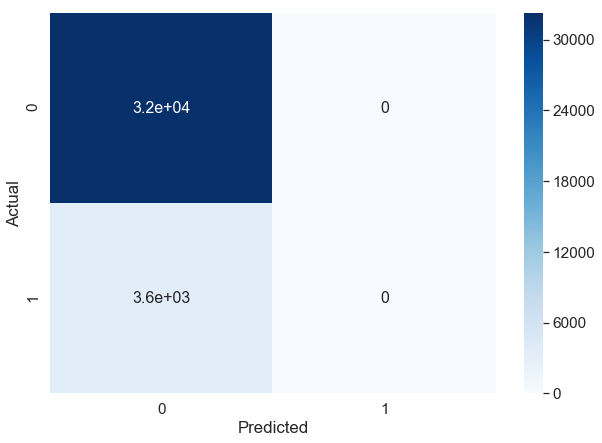

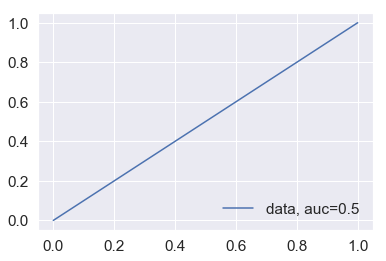

In [34]:
create_paths = [[X_ngram_snow_train, X_ngram_snow_val], [X_ngram_snow_tfidf_train, X_ngram_snow_tfidf_val]]

results_ngram = pd.DataFrame()
import scipy.sparse as sps
for file_name in create_paths:
    try:

        # below code takes care of all the other cases n-gram code:
        trans = file_name[0].split("/")[-1].split(".")[0].split('_')
        print(file_name[0])
        trans = trans[0] + "_" + trans[1] + "_" + trans[2]
        print(trans)
    
        preproc = "snow_stem"
        X_trn=sparse.load_npz(file_name[0])
        X_val = sparse.load_npz(file_name[1])
        results_ngram = results_ngram.append(combined (X_trn, X_val, y_trn, trans, preproc, df_eval, y_val))
     
    except Exception as e:
        print("trace: {}".format(e))
    
   

In [35]:
results_ngram

,model,trans,preproc,set,auc,ap
0,Linear SVMClassifier,ngram_snow_train,snow_stem,trn,0.637493,0.157087
1,Linear SVMClassifier,ngram_snow_train,snow_stem,val,0.636011,0.153921
0,Linear SVMClassifier,ngram_snow_tfidf,snow_stem,trn,0.500000,0.102916
1,Linear SVMClassifier,ngram_snow_tfidf,snow_stem,val,0.500000,0.101565


In [36]:
results_ngram.loc[results_ngram.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,ngram_snow_train,snow_stem,val,0.636011,0.153921
1,Linear SVMClassifier,ngram_snow_tfidf,snow_stem,val,0.500000,0.101565


In [37]:
results.loc[results.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,count,None,val,0.618440,0.147471
1,Linear SVMClassifier,wordcount,lem,val,0.635535,0.154346
1,Linear SVMClassifier,tfidfraw,lem,val,0.647875,0.155463
1,Linear SVMClassifier,tfidfraw_trim,lem,val,0.644183,0.150952
1,Linear SVMClassifier,tfidfnorm,lem,val,0.580078,0.130032
1,Linear SVMClassifier,tfidfnorm_trim,lem,val,0.600702,0.145022


In [38]:
results_up.loc[results_up.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,wordcount_up,lem,val,0.611642,0.130934
1,Linear SVMClassifier,tfidfraw_up,lem,val,0.611642,0.130934
1,Linear SVMClassifier,tfidfnorm_up,lem,val,0.602201,0.150462


#### Snippet to plot word cloud for reviews

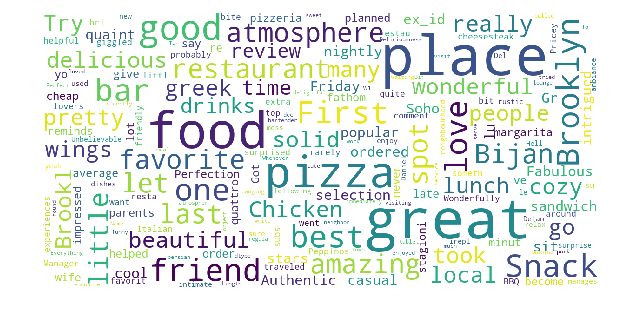

In [39]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
# from nltk.corpus import stopwords
stopwords = set(STOPWORDS)

def show_wordcloud(dataframe, title = None):
    wc = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(dataframe))
    
    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wc)
    plt.show()
    
show_wordcloud(df_trn["review"].loc[df_trn['label']==1])